In [1]:
import os
import glob

import optuna
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [1031]:
df = None
AEZ = 15
PLOTS_DIR = "./plots"
AEZ_CSV_PATH = "./shc_data/AEZS/AGRI_2023-24//"

PRED_VARIABLE = "N" # any value from N, P, K, OC
PLOT_SAVE_PATH = os.path.join(os.path.join(PLOTS_DIR, f"AEZ_{AEZ}"), PRED_VARIABLE)

# Bins for each property defined by soil health portal govt.
bin_dict = {
    "N" : [0, 280, 560, np.inf],
    "P" : [0, 10, 25, np.inf],
    "K" : [0, 120, 280, np.inf],
    "OC" : [0.0, 0.50, 0.75, 1.0]
}

os.makedirs(PLOT_SAVE_PATH, exist_ok=True)

In [1032]:
# OUTPUT_FOLDER = "./rfr_joblib"
# file_name = f"rfr_model_2025-06-24_AEZ_{AEZ}_{PRED_VARIABLE}.joblib"
# model_path = os.path.join(OUTPUT_FOLDER, file_name)
# rf = joblib.load(model_path)
# feature_names = rf.feature_names_in_.tolist()
# feature_names

In [1281]:
# find optimal params for random forest regressor
def objective(trial):
    # Hyperparameters
    params = {
        'n_estimators': 10, #trial.suggest_int('n_estimators', 10, 50),
        'max_depth': 15, #trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    # Train/test split (can also use cross-validation with bin awareness)
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(df, df[PRED_VARIABLE], test_size=0.2, random_state=42)
    bin_counts = X_train_sub['bin'].value_counts()
    weights = X_train_sub['bin'].map(lambda b: 10000 * 1.0 / bin_counts[b])
    model = RandomForestRegressor(**params)
    model.fit(X_train_sub[selected_feature_names], y_train_sub, weights)

    y_pred = model.predict(X_val_sub[selected_feature_names])
    score = r2_score(y_val_sub, y_pred)
    
    return score

In [1034]:
def smape(y_true, y_pred):
    """
    Compute Symmetric Mean Absolute Percentage Error (sMAPE).
    
    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    
    Returns:
    float: sMAPE score (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(np.abs(y_true - y_pred) / (denominator+1e-6)) * 100
    return smape_value

In [1035]:
def residual_mae_rmse_colored(y_true, y_pred, bins, save_plots=False, mode='train'):
    df_eval = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })

    # Define bin size and create bins using y_true
    # bin_size = 50
    # bins = np.arange(df_eval['y_true'].min(), df_eval['y_true'].max() + bin_size, bin_size)
    # bins = np.array([0, 150, 200, 300, 400, 500])
    df_eval['bin'] = pd.cut(df_eval['y_true'], bins=bins, include_lowest=True)
    
    df_eval['residual'] = df_eval['y_pred'] - df_eval['y_true']
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_eval, x='bin', y='residual')
    plt.xticks(rotation=45)
    plt.xlabel("Bin")
    plt.ylabel("Residual (Prediction - True)")
    plt.title("Residuals by Bin")
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_residual.png"))
    plt.show()
    
    bin_metrics = []
    
    for b, group in df_eval.groupby('bin', observed=False):
        if len(group) < 2:
            continue  # skip tiny bins
        mae = mean_absolute_error(group['y_true'], group['y_pred'])
        rmse = np.sqrt(mean_squared_error(group['y_true'], group['y_pred']))
        bin_metrics.append({'bin': b, 'mae': mae, 'rmse': rmse, 'count': len(group)})
    
    metrics_df = pd.DataFrame(bin_metrics)
    
    # MAE plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df, x='bin', y='mae')
    plt.xticks(rotation=45)
    plt.title("MAE per Bin")
    plt.ylabel("MAE")
    plt.xlabel("Bin")
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_mae.png"))
    plt.show()
    
    # RMSE plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df, x='bin', y='rmse')
    plt.xticks(rotation=45)
    plt.title("RMSE per Bin")
    plt.ylabel("RMSE")
    plt.xlabel("Bin")
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_rmse.png"))
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_eval, x='y_true', y='y_pred', hue='bin', palette='tab20', alpha=0.6)
    plt.plot([df_eval['y_true'].min(), df_eval['y_true'].max()], [df_eval['y_true'].min(), df_eval['y_true'].max()], 'k--', label='Ideal')
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.title("True vs Predicted (Colored by Bin)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Nitrogen Bins')
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_bins.png"))
    plt.show()


In [1036]:
def estimation_uncertainity(X_test, y_true, rf, bins, save_plots=False, mode='train'):
    # Assuming rf is your trained RandomForestRegressor model
    # and X_test is your input features
    
    # Combine into a DataFrame
    df_eval = pd.DataFrame({
        'y_true': y_true,
    })

    # Define bin size and create bins using y_true
    bin_size = 50
    # bins = np.arange(df_eval['y_true'].min(), df_eval['y_true'].max() + bin_size, bin_size)
    # bins = np.array([0, 150, 200, 300, 400, 500])
    df_eval['bin'] = pd.cut(df_eval['y_true'], bins=bins, include_lowest=True)
    
    # Get predictions from each tree
    all_tree_preds = np.stack([tree.predict(X_test) for tree in rf.estimators_], axis=1)
    
    # Mean prediction
    mean_preds = all_tree_preds.mean(axis=1)
    
    # Uncertainty estimation: Standard deviation across tree predictions
    std_preds = all_tree_preds.std(axis=1)  # this is your uncertainty measure

    df_eval = df_eval.reset_index()
    sorted_indices = np.argsort(y_true)
    y_true_sorted = y_true.iloc[sorted_indices]
    mean_preds_sorted = mean_preds[sorted_indices]
    std_preds_sorted = std_preds[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 6))
    
    # Main prediction line
    plt.scatter(y_true_sorted, mean_preds_sorted, color='orange', label='Prediction', alpha=0.8)
    
    # Uncertainty band (mean ± std dev)
    plt.fill_between(
        y_true_sorted,
        mean_preds_sorted - std_preds_sorted,
        mean_preds_sorted + std_preds_sorted,
        color='blue',
        alpha=0.2,
        label='± 1 Std Dev'
    )
    
    # plt.figure(figsize=(10, 6))
    # plt.errorbar(y_true, mean_preds, yerr=std_preds, fmt='o', alpha=0.5, label='Prediction ± uncertainty')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Ideal')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Prediction with Uncertainty")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_prediction_uncertainty.png"))
    plt.show()
    
    # Optional: Save to dataframe
    df_eval['y_pred'] = mean_preds
    df_eval['y_std'] = std_preds

    # Bin your data as before
    df_eval['bin'] = pd.cut(df_eval['y_true'], bins=bins)
    
    # Mean uncertainty per bin
    uncertainty_df = df_eval.groupby('bin', observed=False)['y_std'].mean().reset_index()
    uncertainty_df.columns = ['bin', 'uncertainty_std']
    
    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=uncertainty_df, x='bin', y='uncertainty_std', palette='mako', hue='bin', legend=False)
    plt.title("Estimated Prediction Uncertainty per Bin")
    plt.ylabel("Standard Deviation of Tree Predictions")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_uncertainty_barplot.png"))
    plt.show()

In [1037]:
def bin_plots_stats(y_true, y_pred, bins, save_plots=False, mode='train'):
    # Combine into a DataFrame
    df_eval = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    
    # Define bin size and create bins using y_true
    # bin_size = 50
    # bins = np.arange(df_eval['y_true'].min(), df_eval['y_true'].max() + bin_size, bin_size)
    # bins = np.array([0, 150, 200, 300, 400, 500])
    df_eval['bin'] = pd.cut(df_eval['y_true'], bins=bins, include_lowest=True)
    
    # Group by bins and calculate metrics
    stats = []
    for bin_range, group in df_eval.groupby('bin', observed=False):
        if len(group) < 2:  # skip small groups
            continue
        r2 = r2_score(group['y_true'], group['y_pred'])
        rmse = np.sqrt(mean_squared_error(group['y_true'], group['y_pred']))
        mae = mean_absolute_error(group['y_true'], group['y_pred'])
        smape_value = smape(group['y_true'], group['y_pred'])
        
        stats.append({
            'bin': str(bin_range),
            'count': len(group),
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'smape': smape_value
        })
    
        # Visualizing the true vs predicted values
        plt.figure(figsize=(10, 5))
        plt.scatter(group['y_true'], group['y_pred'], color='blue')
        plt.plot([group['y_true'].min(), group['y_true'].max()], [group['y_true'].min(), group['y_true'].max()], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'True vs Predicted Values (Group {bin_range})')
        if save_plots:
            plt.savefig(os.path.join(PLOT_SAVE_PATH, f"{mode}_bin_{str(bin_range)}.png"))
        plt.show()
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(stats)
    # Display or save
    print(stats_df)

In [1038]:
# Add Vegetation Indices (NDVI, EVI, SAVI, NDWI)
def add_indices(df):
    
    # Compute Indices & Add as Columns
    df["NDVI"] = (df["NIR"] - df["RED"]) / (df["NIR"] + df["RED"])
    df["GNDVI"] = (df["NIR"] - df["GREEN"]) / (df["NIR"] + df["GREEN"])
    df["SAVI"] = ((df["NIR"] - df["RED"]) / (df["NIR"] + df["RED"] + 0.5)) * 1.5
    df["NDWI"] = (df["GREEN"] - df["NIR"]) / (df["GREEN"] + df["NIR"])
    df["BI"] = np.sqrt((df["RED"]**2 + df["GREEN"]**2 + df["BLUE"]**2) / 3)
    df["SI"] = (df["RED"] - df["BLUE"]) / (df["RED"] + df["BLUE"])
    df["HI"] = (2 * df["RED"] - df["GREEN"] - df["BLUE"]) / (df["GREEN"] - df["BLUE"])
    df["CI"] = (df["RED"] - df["GREEN"]) / (df["RED"] + df["GREEN"])
    df["RI"] = (df["RED"]**2) / (df["BLUE"] * df["GREEN"]**3)
    df["TGSI"] = (df["SWIR1"] - df["NIR"]) / (df["SWIR1"] + df["NIR"])
    df["NCI"] = (df["SWIR1"] - df["SWIR2"]) / (df["SWIR1"] + df["SWIR2"]) 
    df["EVI"] = (2.5 * (df["NIR"] - df["RED"])) / (df["NIR"] + 6*df["RED"] - 7.5*df["BLUE"] + 1)
    
    return df

## Load the CSV file and apply relevant functions

In [1100]:
df = pd.read_csv(os.path.join(AEZ_CSV_PATH, f"AEZ_{AEZ}.csv"))

df = df.drop(columns=['system:index', 'district', 'village', 'date', 'start_date', 'end_date', 'ae_regcode'])
df = add_indices(df)
df = df.drop(columns=['RED', 'BLUE', 'GREEN', 'SWIR1', 'SWIR2', 'NIR'])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df[df.select_dtypes(np.int64).columns] = df.select_dtypes(np.int64).astype(np.int16)

# Print number of rows & columns in merged DataFrame
print(f"Total Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")
df.head()

Total Rows: 356828, Total Columns: 38


,B,Cu,EC,Fe,K,Mn,N,OC,P,S,...,SAVI,NDWI,BI,SI,HI,CI,RI,TGSI,NCI,EVI
0,1.660,1.600,0.376,50.740002,520.320007,6.690,249.0,0.47,39.619999,7.160000,...,0.192507,-0.305389,0.103771,0.048062,0.181699,-0.030778,83.751434,-0.054096,0.147454,0.232198
1,1.400,0.980,0.375,98.660004,483.730011,10.200,221.0,0.36,124.720001,12.120000,...,0.301107,-0.426277,0.112568,0.041695,0.240163,-0.023937,72.987419,-0.081973,0.175926,0.382379
2,1.647,2.092,0.157,45.180000,142.274994,6.960,237.0,0.42,24.160000,17.289000,...,0.367395,-0.490222,0.098728,0.032224,-0.392522,-0.066783,77.791771,-0.108919,0.222387,0.459233
3,1.702,1.764,0.381,46.959999,306.230011,8.772,244.0,0.45,22.389999,33.828999,...,0.265316,-0.406894,0.103614,0.083650,0.750359,-0.010890,94.915070,-0.043356,0.166703,0.314040
4,1.055,0.472,0.313,22.780001,205.960007,1.498,198.0,0.27,20.927999,8.998000,...,0.351314,-0.491820,0.089246,0.046523,-0.244985,-0.068297,95.826050,-0.110817,0.185112,0.422350


In [1101]:
features = df.drop(columns=['B', 'Cu', 'EC', 'Fe', 'K', 'Mn', 'N', 'OC', 'P', 'S', 'Zn', 'pH']).columns
features

Index(['TWI', 'aspect', 'clay05', 'clay515', 'elevation', 'precipitation',
       'sand05', 'sand515', 'silt05', 'silt515', 'slope', 'temp', 'longitude',
       'latitude', 'NDVI', 'GNDVI', 'SAVI', 'NDWI', 'BI', 'SI', 'HI', 'CI',
       'RI', 'TGSI', 'NCI', 'EVI'],
      dtype='object')

In [1102]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[features])
low_variance_cols = [col for col, var in zip(features, selector.variances_) if var < 0.01]
low_variance_cols

['temp', 'GNDVI', 'SAVI', 'NDWI', 'BI', 'SI', 'CI', 'TGSI', 'NCI', 'EVI']

### Outliers removed

- Remove top10 from AEZ 15 (nitrogen)
- Remove top5 from AEZ 16 (nitrogen)
- Remove top1 from AEZ 17 (nitrogen)

In [1103]:
df = df[~df[PRED_VARIABLE].isin(df[PRED_VARIABLE].nlargest(10))]

In [1104]:
df[PRED_VARIABLE].describe()

count    356818.000000
mean        455.459045
std         129.322662
min           0.000000
25%         377.000000
50%         514.000000
75%         554.533020
max         883.000000
Name: N, dtype: float64

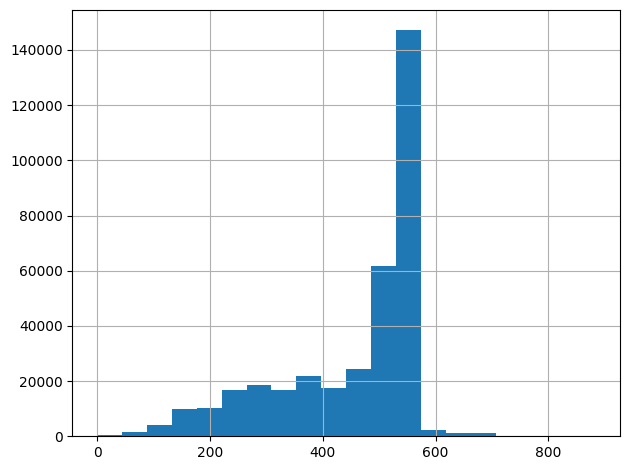

In [1105]:
df[PRED_VARIABLE].hist(bins=20)
plt.tight_layout()
plt.show()

## Apply binning on the data, set `desired_total_bins` to split the data accordingly into finer or coarser bins

target_samples_per_bin=89205
Low region: 50965 points → 1 sub-bins
Mid region: 242127 points → 3 sub-bins
High region: 63726 points → 1 sub-bins
final_bin
0     50965
1     36294
2     48611
3    157222
4     63726
Name: count, dtype: int64


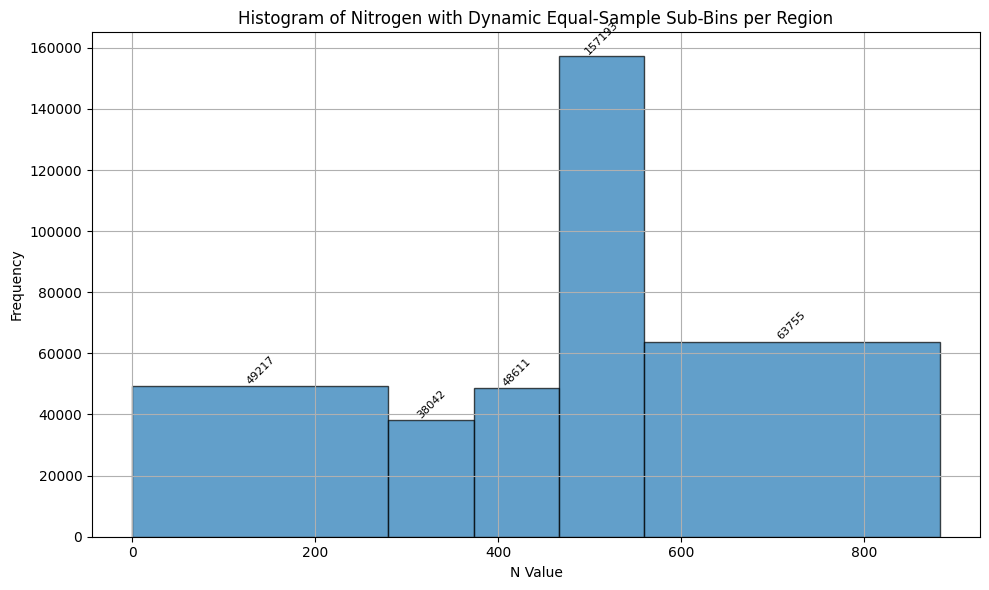

In [1106]:
# Define base bins for NITROGEN: Low (0–280), Mid (280–560), High (560–max)
base_bins = bin_dict[PRED_VARIABLE]
df['base_bin'] = pd.cut(df[PRED_VARIABLE], bins=base_bins, labels=["Low", "Mid", "High"], include_lowest=True)

# Estimate a dynamic target to get ~6 total bins (adjustable between 5–7)
total_points = len(df)
desired_total_bins = 4 # you can randomize between 5–7 if needed
target_samples_per_bin = int(np.ceil(total_points / desired_total_bins))

print(f"{target_samples_per_bin=}")

custom_bins = []

for i, label in enumerate(["Low", "Mid", "High"]):
    subset = df[df['base_bin'] == label]
    if not subset.empty:
        n_points = len(subset)
        sub_bins = max(1, int(np.ceil(n_points / target_samples_per_bin)))
        print(f"{label} region: {n_points} points → {sub_bins} sub-bins")
        edges = np.linspace(subset[PRED_VARIABLE].min(), subset[PRED_VARIABLE].max(), sub_bins + 1)
        # Skip the first edge for all but the first region to avoid overlap
        if i > 0:
            edges = edges[1:]
        custom_bins.extend(edges)

# Sort and ensure uniqueness
custom_bins = sorted(set(custom_bins))
bins = custom_bins
df['bin'] = pd.cut(df[PRED_VARIABLE], bins=bins, include_lowest=True)

# Assign final bins
df['final_bin'] = pd.cut(df[PRED_VARIABLE], bins=custom_bins, labels=False, include_lowest=True)

# Check bin counts
bin_counts = df['final_bin'].value_counts().sort_index()
print(bin_counts)

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bin_edges, _ = plt.hist(df[PRED_VARIABLE], bins=custom_bins, edgecolor='black', alpha=0.7)

# Add count labels above bars
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text((bin_edges[i] + bin_edges[i+1]) / 2, counts[i], str(int(counts[i])),
                 ha='center', va='bottom', fontsize=8, rotation=45)

plt.xlabel(f'{PRED_VARIABLE} Value')
plt.ylabel('Frequency')
plt.title('Histogram of Nitrogen with Dynamic Equal-Sample Sub-Bins per Region')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_SAVE_PATH, "binning.png"))
plt.show()

In [1107]:
len(counts), len(bins)

(5, 6)

In [1108]:
count_df = pd.DataFrame({"bin": bins[:-1], "count": counts})
count_df

,bin,count
0,0.000000,49217.0
1,280.000000,38042.0
2,373.453339,48611.0
3,466.726685,157193.0
4,560.000000,63755.0


In [1109]:
df['bin'].unique()

[(-0.001, 280.0], (280.0, 373.453], (373.453, 466.727], (560.0, 883.0], (466.727, 560.0]]
Categories (5, interval[float64, right]): [(-0.001, 280.0] < (280.0, 373.453] < (373.453, 466.727] < (466.727, 560.0] < (560.0, 883.0]]

## Select the feature names by reviewing the feature importance and remove them iteratively

In [1282]:
selected_feature_names = [
    # 'TWI', 
    # 'aspect', 
    # 'slope', 
    'temp',
    # 'GNDVI',
    # 'NDVI', 
    # 'BI', 
    # 'SI', 
    # 'HI', 
    # 'CI', 
    'RI',
    'elevation', 
    'precipitation', 
    'clay05', 
    'sand05',
    'silt05', 
    # 'clay515',
    'sand515',
    # 'silt515',
    # 'TGSI',
    # 'NCI',
    # 'SAVI',
    # 'EVI',
    # 'NDWI',
    'longitude',
    'latitude'
]

y = df[PRED_VARIABLE]
X = df

In [1283]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

[I 2025-06-29 23:18:16,619] A new study created in memory with name: no-name-8b066daf-dfba-4ef5-ac4a-80ed4b9e9f47
[I 2025-06-29 23:18:18,890] Trial 0 finished with value: 0.7508854242574912 and parameters: {'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.5422508015542877}. Best is trial 0 with value: 0.7508854242574912.
[I 2025-06-29 23:18:25,826] Trial 1 finished with value: 0.7510117800691948 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.8391127453940046}. Best is trial 1 with value: 0.7510117800691948.
[I 2025-06-29 23:18:30,424] Trial 2 finished with value: 0.7503042295682014 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.512722369269002}. Best is trial 1 with value: 0.7510117800691948.
[I 2025-06-29 23:18:37,014] Trial 3 finished with value: 0.7507069362292984 and parameters: {'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.8331893773113774}. Best is trial 1 with value: 0.7510

In [1284]:
print("Best trial:")
print(f"  R2 score: {study.best_value}")
print(f"  Params: {study.best_trial.params}")

Best trial:
  R2 score: 0.7520568623555776
  Params: {'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.8145077676476332}


In [1285]:
# Split data into training (80%) and testing (20%)
best_split=None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Rerun from this cell to retrieve train and test results for the best model

In [1301]:
if best_split is not None:
    A = df
    train_idx, test_idx = best_split
    X_train, X_test = A.iloc[train_idx], A.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [1302]:
# y_train.hist(bins=bins)
# plt.title("Train Dataset")
# plt.xticks(bins, rotation=45)
# plt.tight_layout()
# plt.show()
# y_test.hist(bins=bins)
# plt.title("Test Dataset")
# plt.xticks(bins, rotation=45)
# plt.tight_layout()
# plt.show()

## Training the Model

In [1303]:
# weights = 1 / num points in bin
bin_counts = X_train['bin'].value_counts()
weights = X_train['bin'].map(lambda b: 10000 * 1.0 / bin_counts[b])

print(f"{weights.unique()=}")

# Initialize and train Random Forest model
N_ESTIMATORS = 10
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = study.best_trial.params['min_samples_split']
MIN_SAMPLES_LEAF = study.best_trial.params["min_samples_leaf"]
MAX_FEATURES = study.best_trial.params["max_features"]

rf = RandomForestRegressor(
    n_estimators=N_ESTIMATORS, 
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    max_features=MAX_FEATURES,
    random_state=42, 
    n_jobs=-1,
)

rf.fit(X_train[selected_feature_names], y_train, weights)

weights.unique()=[0.217884, 0.306796, 0.228311, 0.174593, 0.070637]
Categories (5, float64): [0.217884 < 0.306796 < 0.228311 < 0.070637 < 0.174593]


,n_estimators,10
,criterion,'squared_error'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.8145077676476332
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1304]:
y_pred = rf.predict(X_train[selected_feature_names])

In [1305]:
# Evaluate model performance
r2 = r2_score(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
smape_value = smape(y_train, y_pred)
print("Model performance on Train Set")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"sMAPE: {smape_value:.4f}")

Model performance on Train Set
R² Score: 0.7819
RMSE: 60.3903
MAE: 42.5364
sMAPE: 11.6864


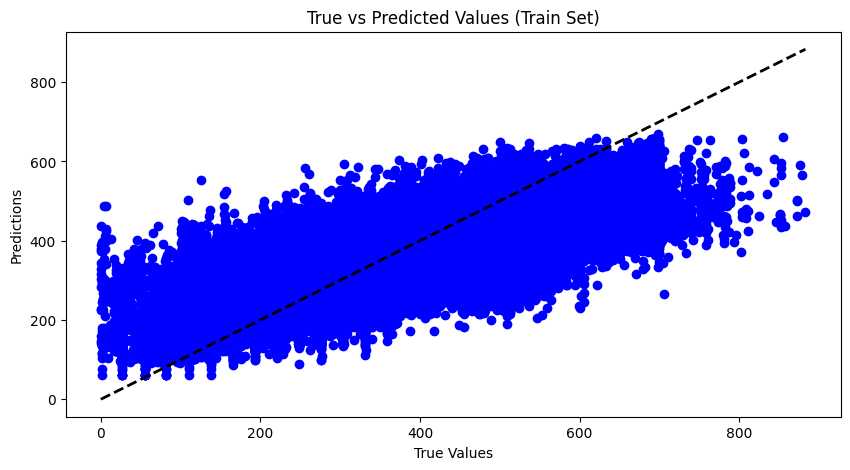

In [1306]:
# Visualizing the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_pred, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values (Train Set)')
plt.savefig(os.path.join(PLOT_SAVE_PATH, "train_true_vs_pred.png"))
plt.show()

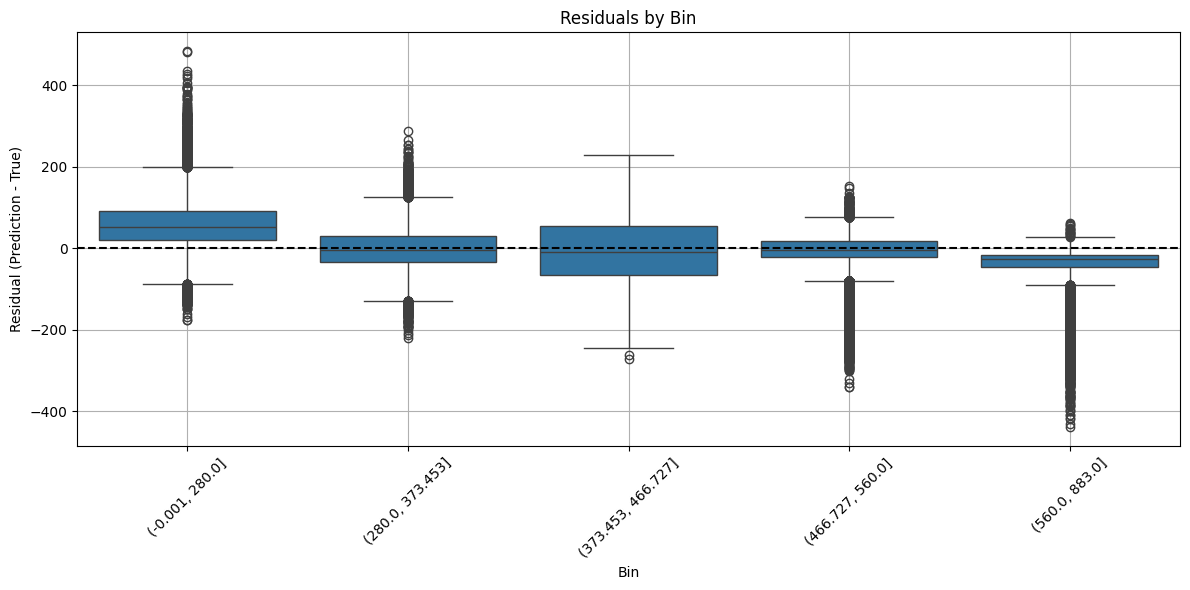

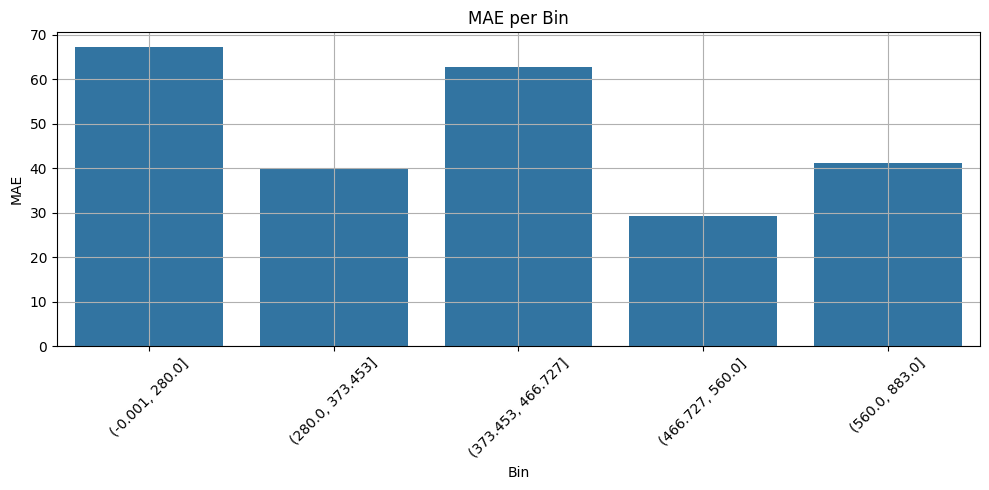

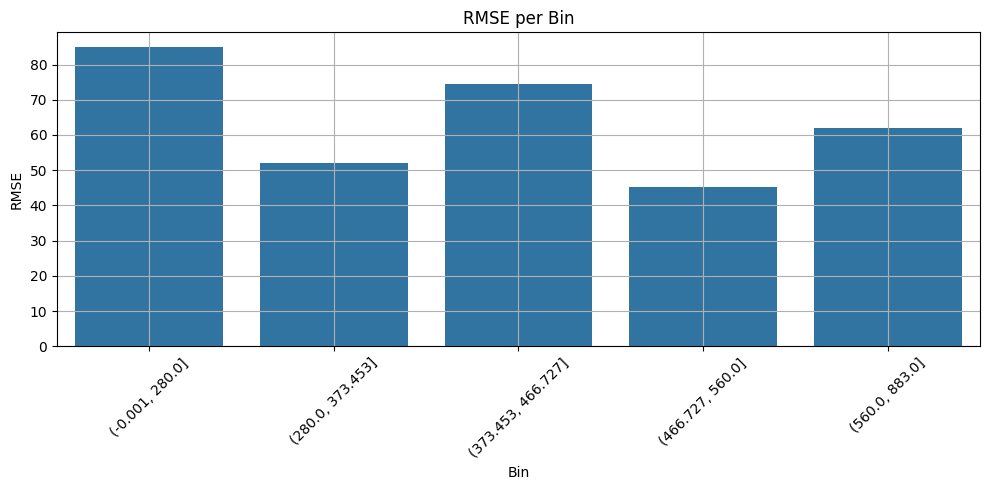

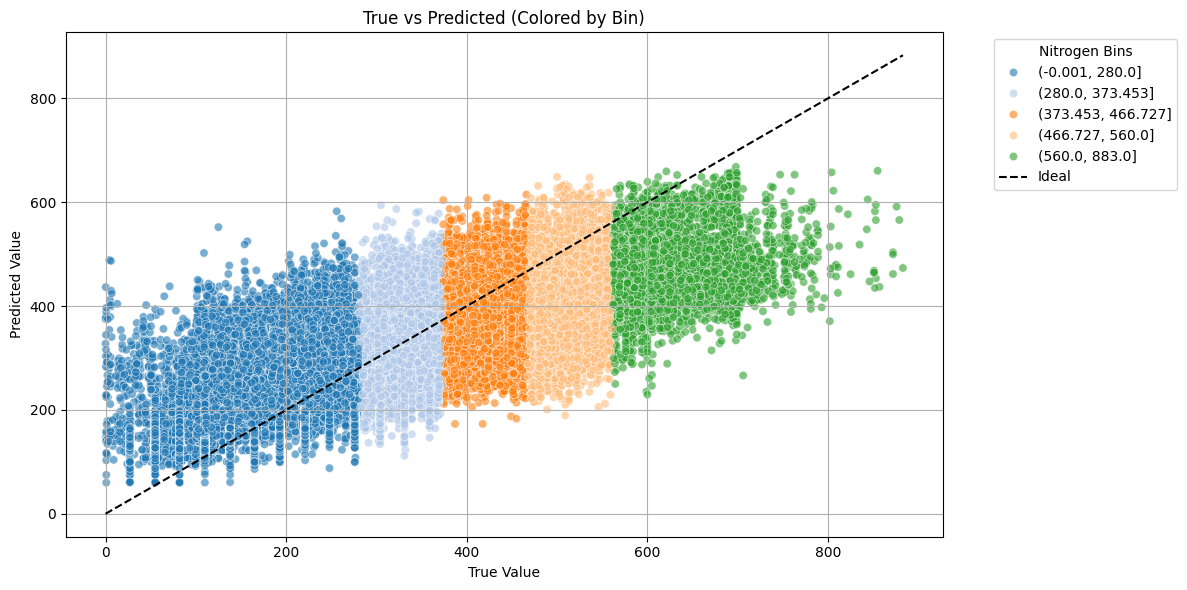

/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted with

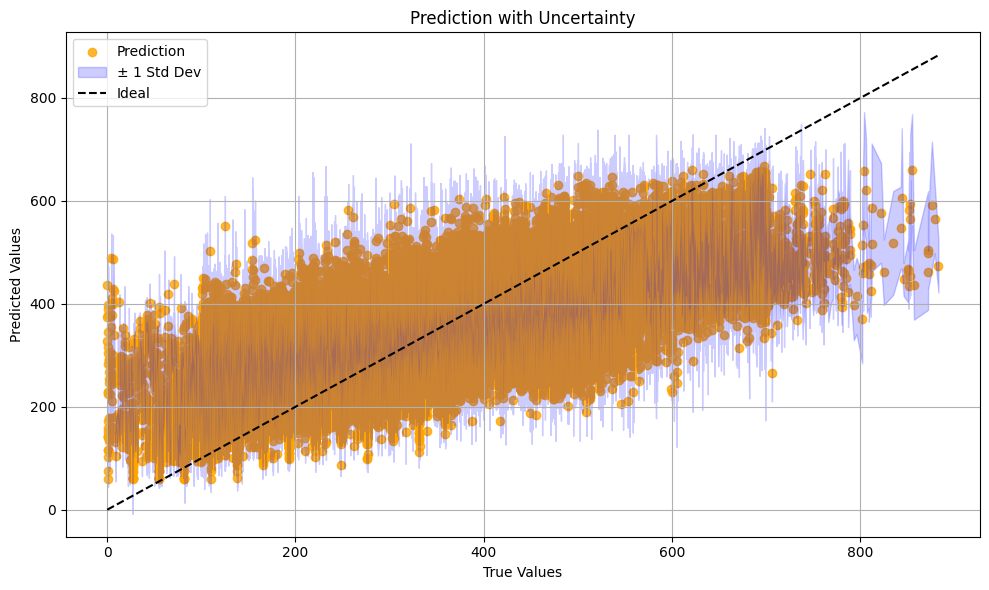

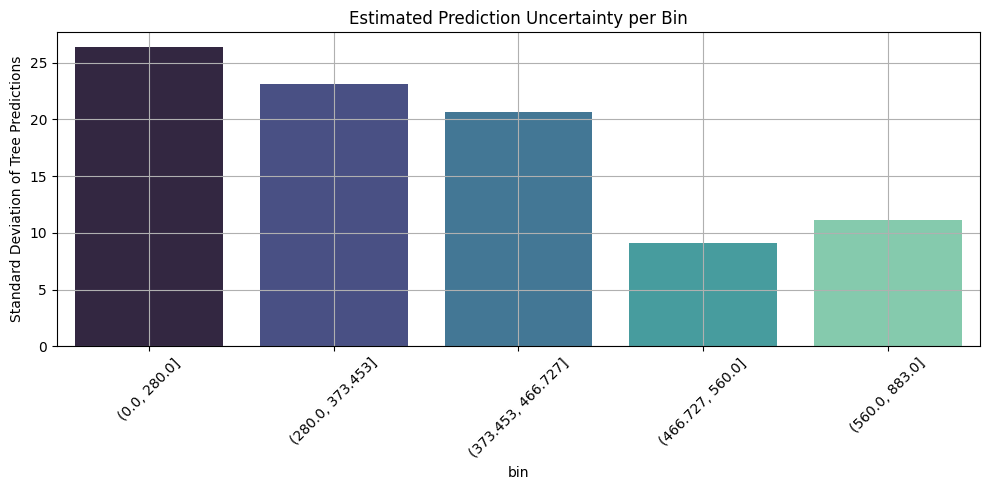

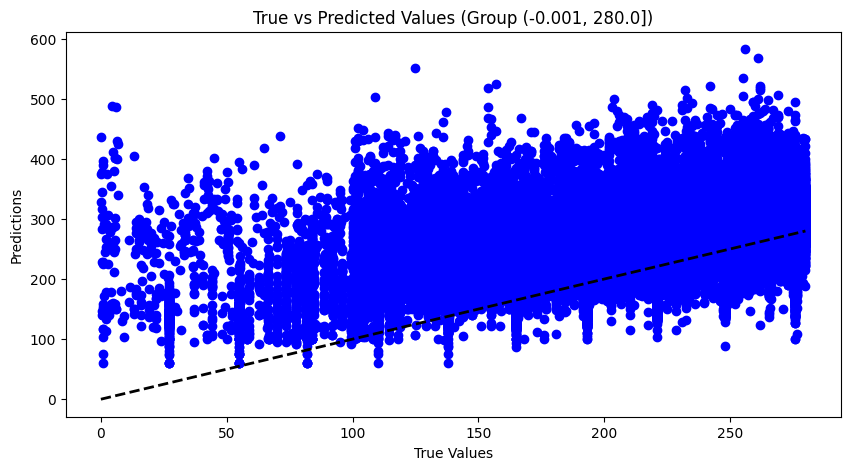

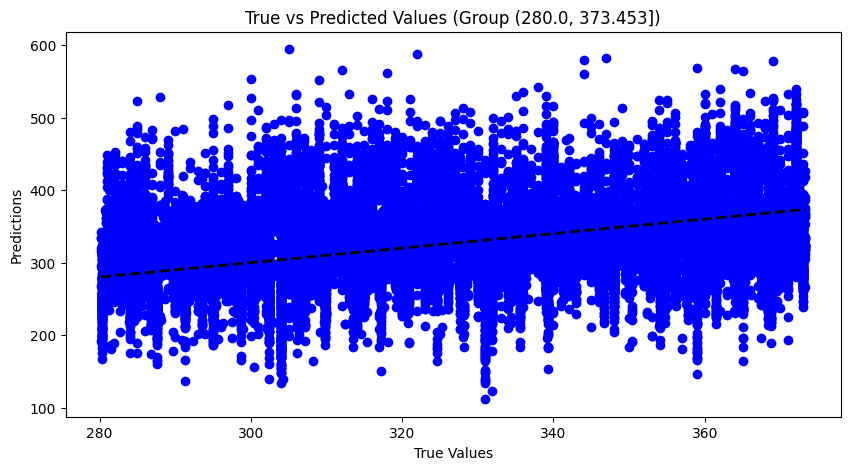

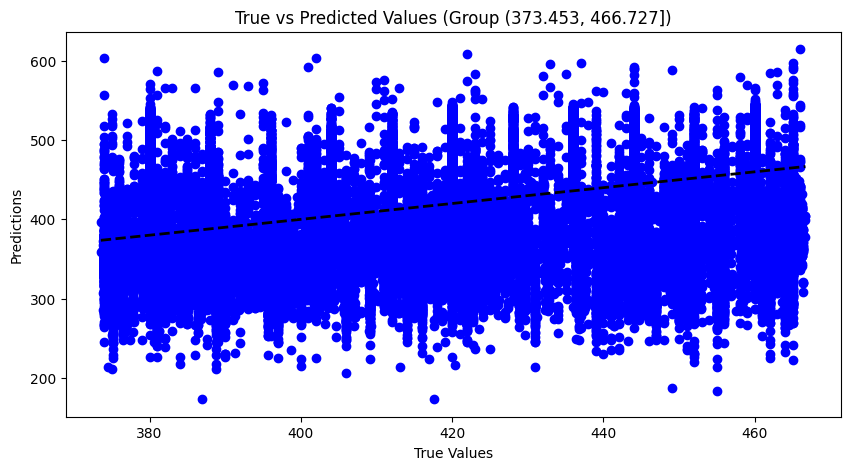

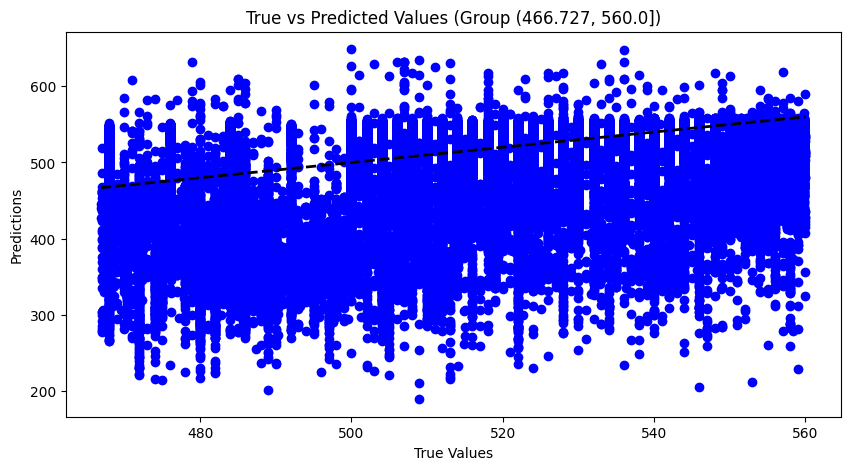

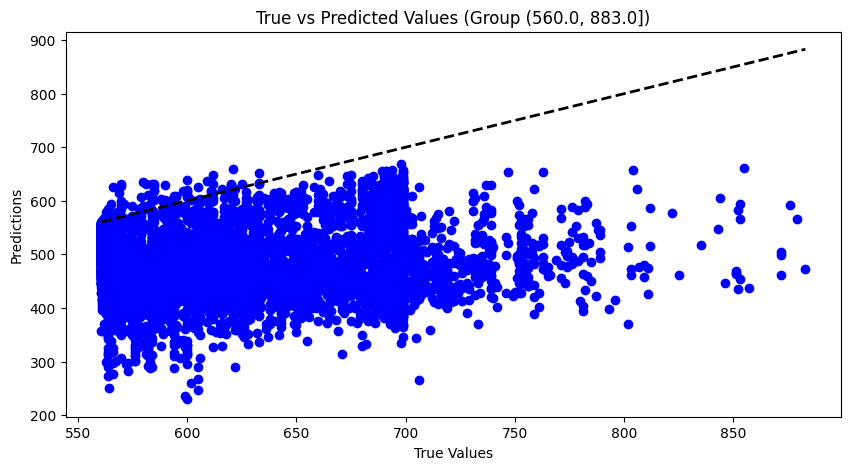

                  bin   count       rmse        r2        mae      smape
0     (-0.001, 280.0]   45896  84.896926 -1.117505  67.200161  30.567448
1    (280.0, 373.453]   32595  52.095983 -2.642566  40.026249  12.204639
2  (373.453, 466.727]   43800  74.432054 -5.419454  62.856277  15.354238
3    (466.727, 560.0]  141569  45.202137 -2.945198  29.344976   5.968550
4      (560.0, 883.0]   57276  61.976943 -4.954761  41.267546   7.590046


In [1307]:
residual_mae_rmse_colored(y_train, y_pred, bins, save_plots=True, mode='train')
estimation_uncertainity(X_train[selected_feature_names], y_train, rf, bins, save_plots=True, mode='train')
bin_plots_stats(y_train, y_pred, bins, save_plots=True, mode='train')

In [1308]:
# Make predictions
y_pred = rf.predict(X_test[selected_feature_names])

In [1309]:
# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
smape_value = smape(y_test, y_pred)
print("Model performance on Test Set")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"sMAPE: {smape_value:.4f}")

Model performance on Test Set
R² Score: 0.7557
RMSE: 63.9368
MAE: 44.6773
sMAPE: 12.3211


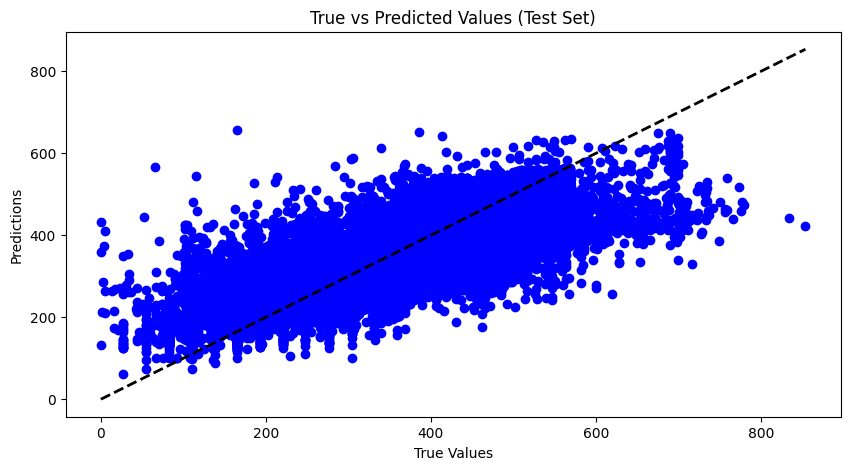

In [1310]:
# Visualizing the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values (Test Set)')
plt.savefig(os.path.join(PLOT_SAVE_PATH, "test_true_vs_pred.png"))
plt.show()

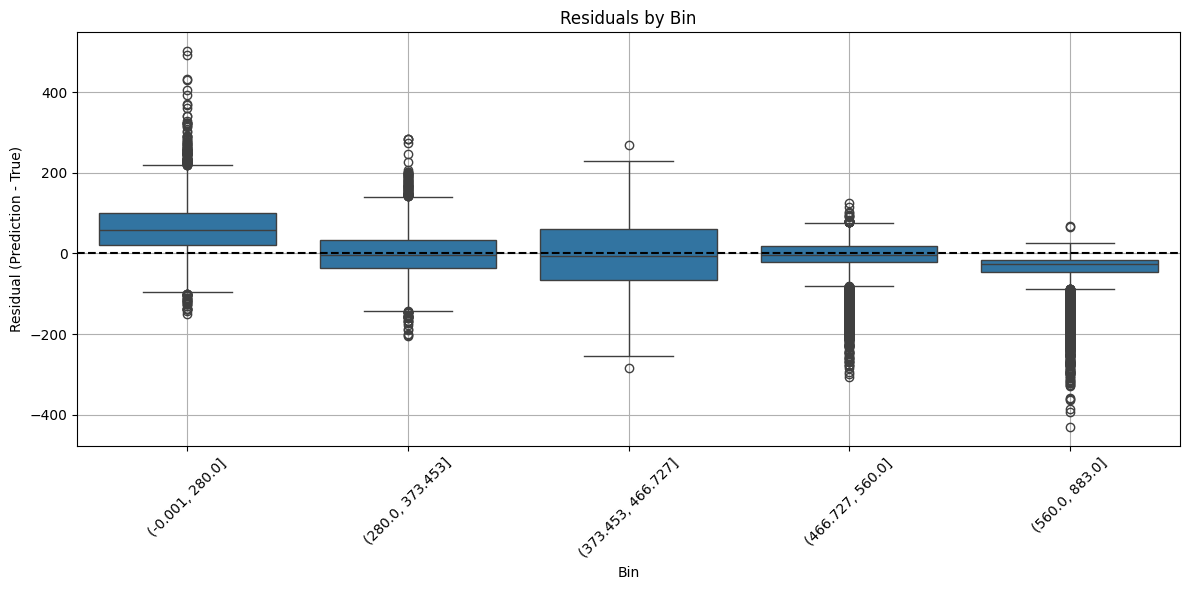

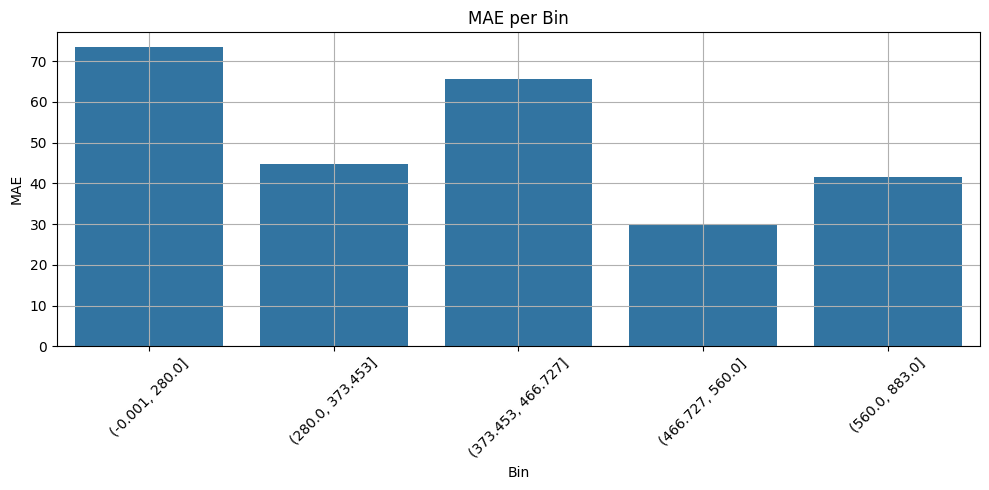

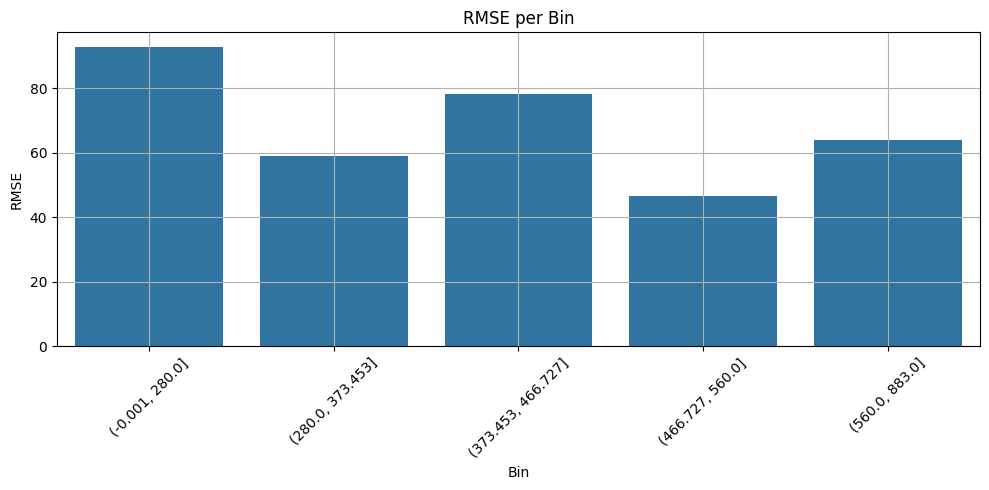

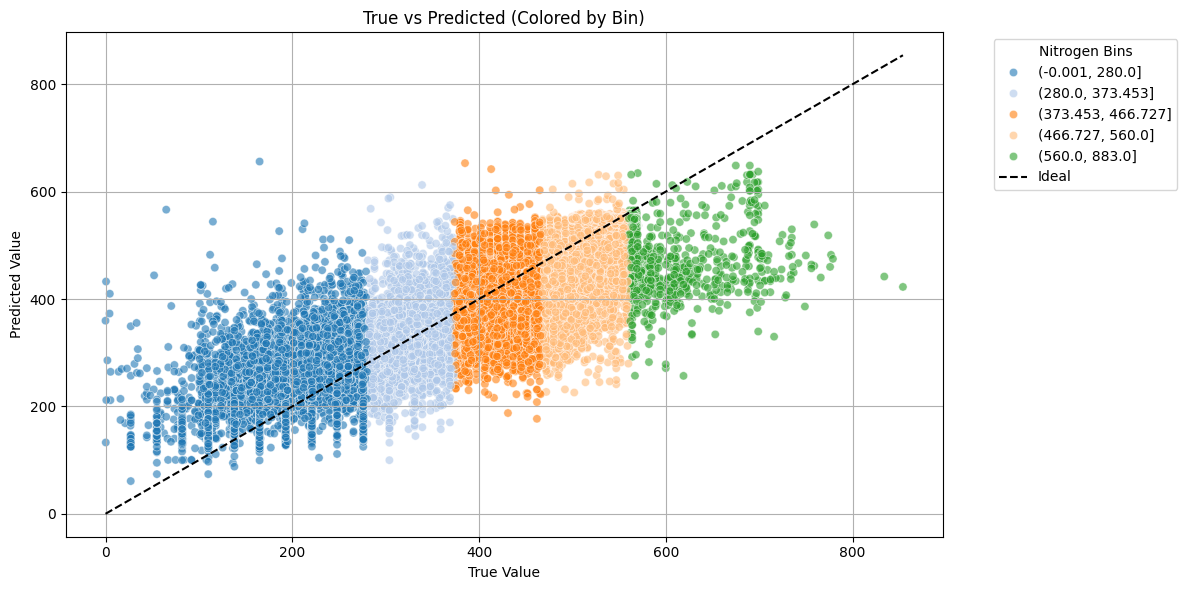

/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/aakash01/Documents/shc/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted with

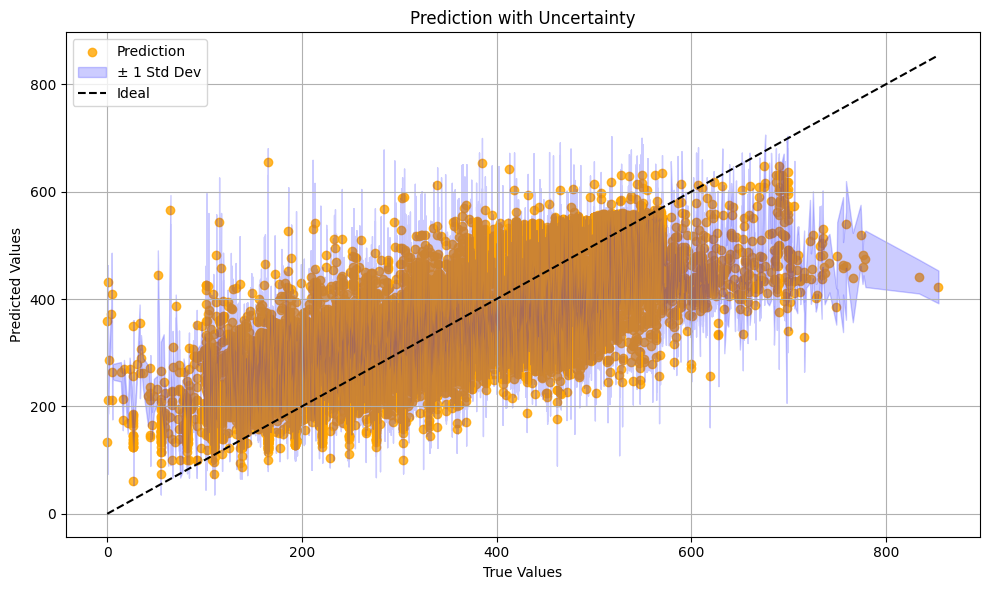

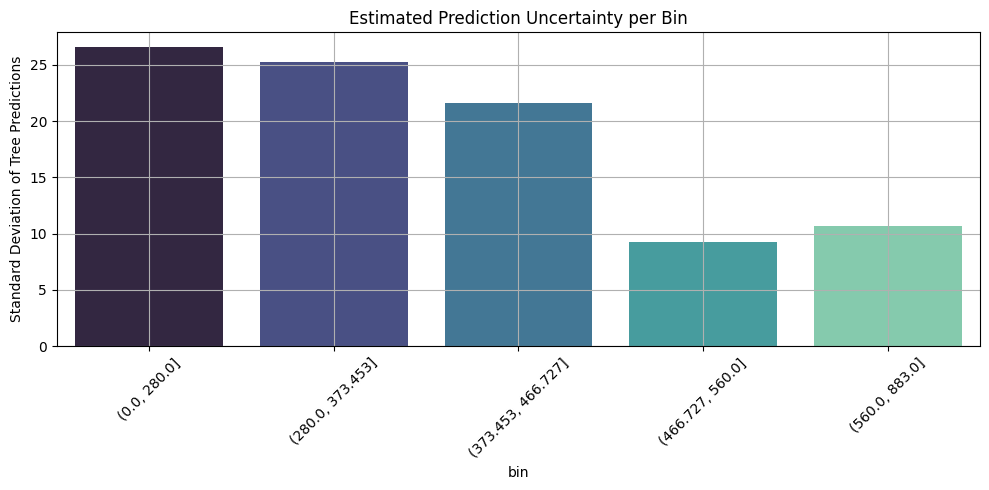

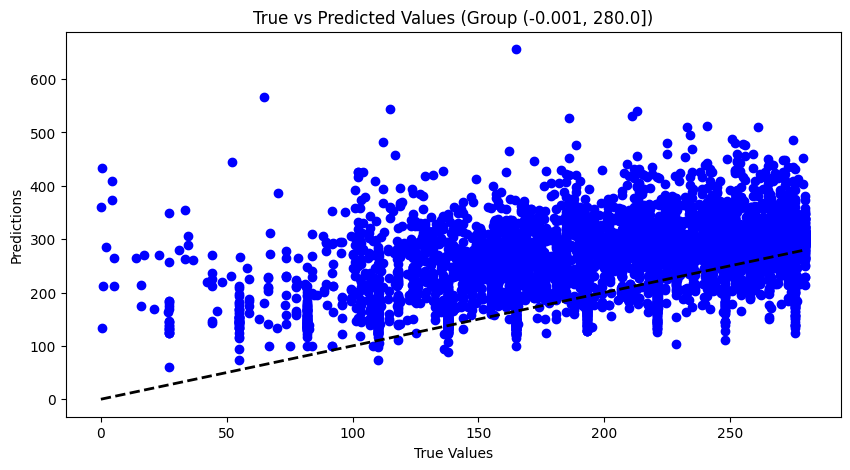

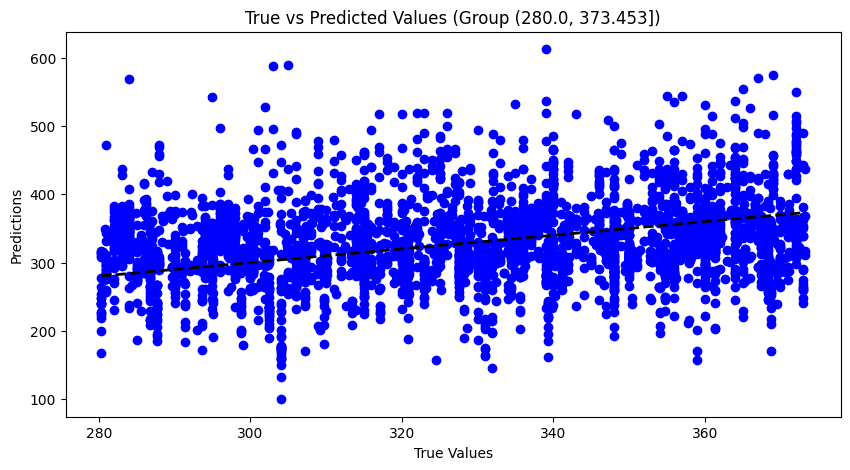

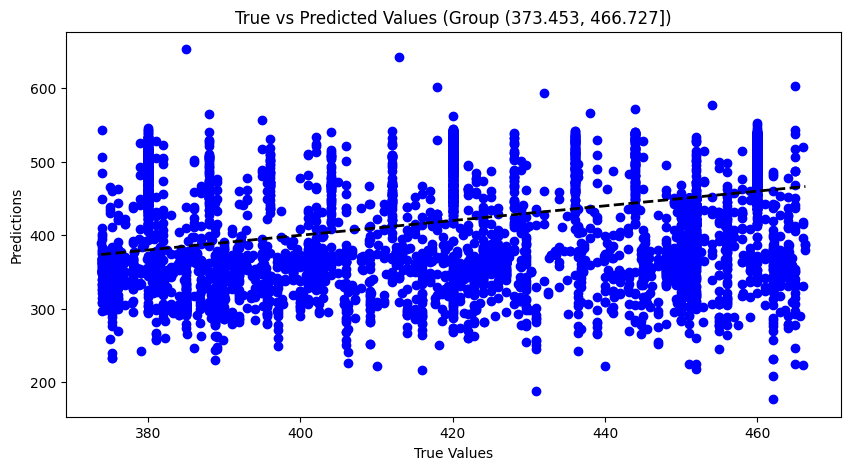

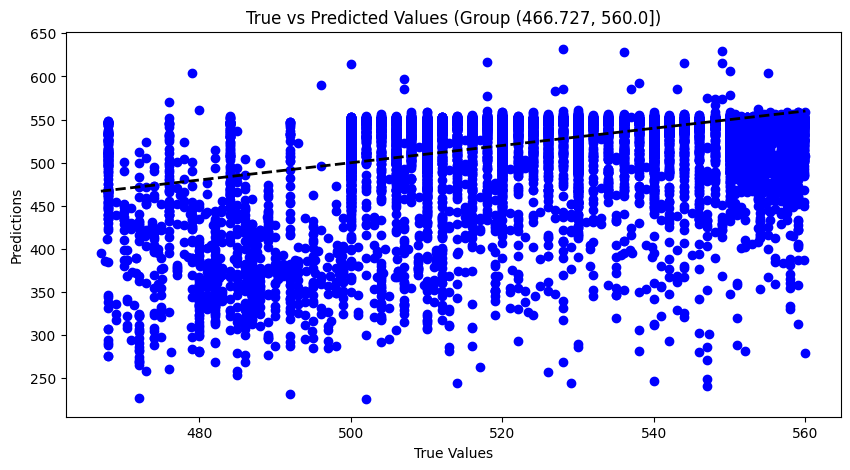

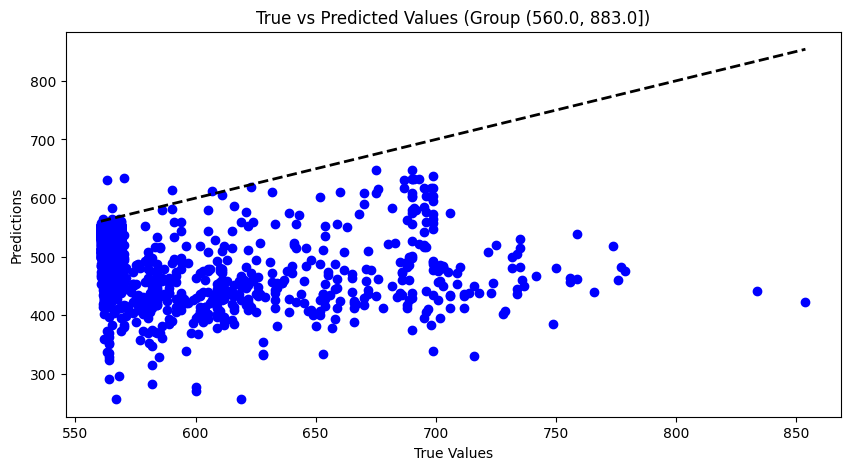

                  bin  count       rmse        r2        mae      smape
0     (-0.001, 280.0]   5069  92.628893 -1.490309  73.389288  32.727869
1    (280.0, 373.453]   3699  58.861751 -3.745458  44.815062  13.714909
2  (373.453, 466.727]   4811  78.064679 -6.043636  65.711461  16.032766
3    (466.727, 560.0]  15653  46.595703 -3.193579  30.126788   6.143613
4      (560.0, 883.0]   6450  63.797615 -6.046898  41.655955   7.707170


In [1311]:
residual_mae_rmse_colored(y_test, y_pred, bins, save_plots=True, mode='test')
estimation_uncertainity(X_test[selected_feature_names], y_test, rf, bins, save_plots=True, mode='test')
bin_plots_stats(y_test, y_pred, bins, save_plots=True, mode='test')

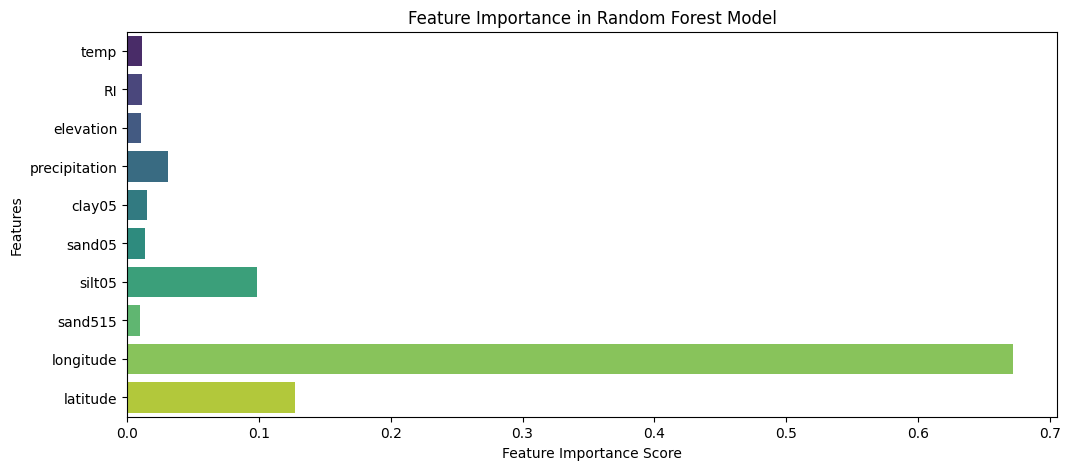

In [1312]:
# Feature importance plot
plt.figure(figsize=(12, 5))
importance = rf.feature_importances_
feature_names = X[selected_feature_names].columns
sns.barplot(x=importance, y=feature_names, palette="viridis", hue=feature_names)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.savefig(os.path.join(PLOT_SAVE_PATH, "feature_importance.png"))
plt.show()

In [1313]:
# Create a DataFrame for Sorting
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
})

# Sort in Descending Order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Print Sorted Feature Importances
print(feature_importance_df)

         Feature  Importance
8      longitude    0.672073
9       latitude    0.127556
6         silt05    0.098728
3  precipitation    0.030752
4         clay05    0.015168
5         sand05    0.013615
1             RI    0.011203
0           temp    0.010959
2      elevation    0.010152
7        sand515    0.009793


## 10-Fold Cross-Validation to get the Best Model (Acc. to Test R2 score)

In [1299]:
A = df
y = A[PRED_VARIABLE]

# Initialize 5-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
counter = 0

models = []  # List to store models
scores = []  # List to store R² scores
train_test_split_idx = [] # List to store the perfect train-test split

# Perform manual cross-validation
for train_idx, test_idx in kf.split(A, A[PRED_VARIABLE]):
# for train_idx, test_idx in kf.split(df, df['ae_regcode']):
    X_train, X_test = A.iloc[train_idx], A.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    bin_counts = X_train['bin'].value_counts()
    weights = X_train['bin'].map(lambda b: 10000 * 1.0 / bin_counts[b])

    train_test_split_idx.append((train_idx, test_idx))
    
    # Train Random Forest model
    model = RandomForestRegressor(
        n_estimators=N_ESTIMATORS, 
        max_depth=MAX_DEPTH, 
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        max_features=MAX_FEATURES,
        random_state=42, 
        n_jobs=-1,
    )
    model.fit(X_train[selected_feature_names], y_train, sample_weight=weights)
    models.append(model)

    y_pred = model.predict(X_test[selected_feature_names]) 
    
    # Evaluate model
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)

    print(f"K Fold No. {counter+1}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"sMAPE: {smape_value:.4f}")

    print("=======================")
    
    scores.append(r2)
    counter += 1

# Print performance
print("Cross-validation R² scores:", scores)
print("Mean R² score:", np.mean(scores))

# Retrieve the best model (highest R²)
best_model_idx = np.argmax(scores)
best_model = models[best_model_idx]
best_split = train_test_split_idx[best_model_idx]
print(f"Best model is from fold {best_model_idx+1} with R² = {scores[best_model_idx]:.4f}")

K Fold No. 1
R² Score: 0.7491
RMSE: 64.7361
MAE: 45.1471
sMAPE: 12.4414
K Fold No. 2
R² Score: 0.7549
RMSE: 63.9719
MAE: 44.6650
sMAPE: 12.2918
K Fold No. 3
R² Score: 0.7530
RMSE: 64.6509
MAE: 45.0382
sMAPE: 12.4434
K Fold No. 4
R² Score: 0.7520
RMSE: 64.3224
MAE: 44.8957
sMAPE: 12.3176
K Fold No. 5
R² Score: 0.7550
RMSE: 63.9487
MAE: 44.7815
sMAPE: 12.3715
K Fold No. 6
R² Score: 0.7512
RMSE: 64.6366
MAE: 45.1479
sMAPE: 12.4231
K Fold No. 7
R² Score: 0.7557
RMSE: 63.9368
MAE: 44.6773
sMAPE: 12.3211
K Fold No. 8
R² Score: 0.7493
RMSE: 64.8174
MAE: 45.1357
sMAPE: 12.4106
K Fold No. 9
R² Score: 0.7437
RMSE: 65.2107
MAE: 45.1813
sMAPE: 12.3405
K Fold No. 10
R² Score: 0.7497
RMSE: 64.6023
MAE: 44.9477
sMAPE: 12.3997
Cross-validation R² scores: [0.7490782877143332, 0.7548703236540977, 0.7529711146665115, 0.7520246879323758, 0.754993277189038, 0.7512372559284012, 0.7556712052302497, 0.7492632289199077, 0.7437375230616599, 0.7496769173327849]
Mean R² score: 0.751352382162936
Best model is from

In [1300]:
# Save the model as joblib file
OUTPUT_FOLDER = "./rfr_joblib"
file_name = f"rfr_model_{str(datetime.datetime.today().date())}_AEZ_{AEZ}_{PRED_VARIABLE}.joblib"
model_path = os.path.join(OUTPUT_FOLDER, file_name)
joblib.dump(best_model, model_path)

['./rfr_joblib/rfr_model_2025-06-29_AEZ_15_N.joblib']